In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import time
import matplotlib.pyplot as plt

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 70719912.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
!pip install torchsummary

In [8]:
!pip install timm

In [18]:
import torch
import timm
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings

warnings.filterwarnings("ignore")

model = timm.create_model('deit_base_distilled_patch16_224', pretrained=True)

for name, param in model.named_parameters():
    if 'blocks.11' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.head = nn.Linear(model.head.in_features, 10)
model.head_dist = nn.Linear(model.head_dist.in_features, 10)


model.classifier = nn.Sequential(
    nn.Linear(25088, 256),
    nn.ELU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10),
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (3, 224, 224))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=3, verbose=True, min_lr=1e-7)



print("\nLayer status:")
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 198, 768]               0
          Identity-5             [-1, 198, 768]               0
          Identity-6             [-1, 198, 768]               0
         LayerNorm-7             [-1, 198, 768]           1,536
            Linear-8            [-1, 198, 2304]       1,771,776
          Identity-9          [-1, 12, 198, 64]               0
         Identity-10          [-1, 12, 198, 64]               0
           Linear-11             [-1, 198, 768]         590,592
          Dropout-12             [-1, 198, 768]               0
        Attention-13             [-1, 198, 768]               0
         Identity-14             [-1, 1

In [19]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
model.to(device)


Tesla T4


VisionTransformerDistilled(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 

training started on Tesla T4
Epoch 1/8, Loss: 0.1438, Val Loss: 0.1105, Accuracy: 95.46%, Val Accuracy: 96.42%, Train Time: 633.18s, Val Time: 107.13s
Epoch 2/8, Loss: 0.0509, Val Loss: 0.1070, Accuracy: 98.33%, Val Accuracy: 96.76%, Train Time: 632.98s, Val Time: 107.34s
Epoch 3/8, Loss: 0.0239, Val Loss: 0.1371, Accuracy: 99.19%, Val Accuracy: 96.39%, Train Time: 633.37s, Val Time: 107.54s
Epoch 4/8, Loss: 0.0149, Val Loss: 0.1606, Accuracy: 99.50%, Val Accuracy: 96.44%, Train Time: 634.18s, Val Time: 107.64s
Epoch 5/8, Loss: 0.0111, Val Loss: 0.1448, Accuracy: 99.63%, Val Accuracy: 96.82%, Train Time: 633.53s, Val Time: 107.27s
Epoch 6/8, Loss: 0.0099, Val Loss: 0.1658, Accuracy: 99.69%, Val Accuracy: 96.63%, Train Time: 633.38s, Val Time: 107.28s
Epoch 7/8, Loss: 0.0084, Val Loss: 0.1527, Accuracy: 99.73%, Val Accuracy: 96.88%, Train Time: 633.36s, Val Time: 107.36s
Epoch 8/8, Loss: 0.0086, Val Loss: 0.1554, Accuracy: 99.73%, Val Accuracy: 96.84%, Train Time: 633.50s, Val Time: 107

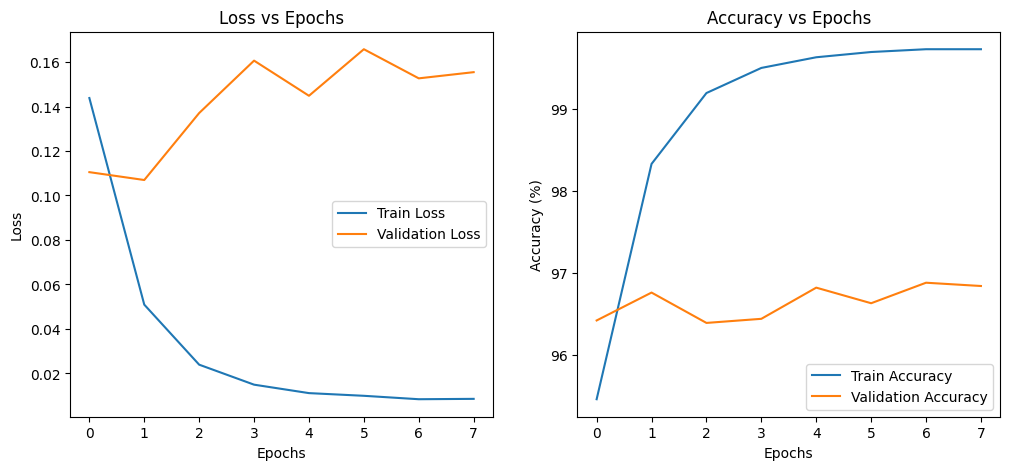

Average Training Time per Epoch: 633.44s
Average Validation Time per Epoch: 107.35s


In [20]:

num_epochs = 8
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_times = []
val_times = []
print('training started on',torch.cuda.get_device_name(0))
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct_train / total_train)

    epoch_time = time.time() - start_time
    train_times.append(epoch_time)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_start_time = time.time()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_time = time.time() - val_start_time
    val_times.append(val_epoch_time)

    val_losses.append(running_val_loss / len(testloader))
    val_accuracies.append(100 * correct_val / total_val)
    scheduler.step(val_accuracies[-1])

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Val Accuracy: {val_accuracies[-1]:.2f}%, '
          f'Train Time: {epoch_time:.2f}s, '
          f'Val Time: {val_epoch_time:.2f}s')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()

avg_train_time = sum(train_times) / num_epochs
avg_val_time = sum(val_times) / num_epochs
print(f'Average Training Time per Epoch: {avg_train_time:.2f}s')
print(f'Average Validation Time per Epoch: {avg_val_time:.2f}s')


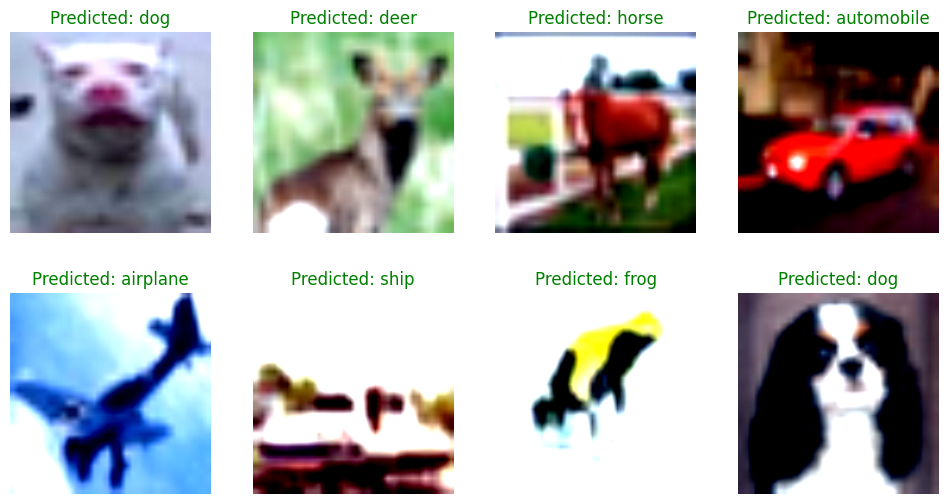

In [22]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)

model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

images = images.cpu()
predicted = predicted.cpu()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3)
axes = axes.ravel()

for i in range(8):
    image = images[i] / 2 + 0.5  
    npimg = image.numpy()
    axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[i].set_title(f'Predicted: {trainloader.dataset.classes[predicted[i]]}', color='green' if predicted[i] == labels[i] else 'red')
    axes[i].axis('off')

plt.show()